In [1]:
import jtrace
import os
import numpy as np
from ipywidgets import interact
import ipywidgets as widgets
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
LSST_r_fn = os.path.join(jtrace.datadir, "LSST", "LSST_r.yaml")
telescope = jtrace.Telescope.makeFromYAML(LSST_r_fn)

In [3]:
for name, surface in telescope.surfaces.items():
    print(name, surface['surface'])

M1 Asphere(19.835, -1.215, [-0, -1.381e-09, ], 0)
M2 Asphere(6.788, -0.222, [-0, 1.274e-05, 9.68e-07, ], 6.1562)
M3 Asphere(8.3445, 0.155, [-0, 4.5e-07, 8.15e-09, ], -0.2338)
L1 Sphere(2.824, 3.39747)
L1E Sphere(5.021, 3.4797)
L2 Plane(3.89234)
L2E Asphere(2.529, -1.57, [-0, -0.001656, ], 3.92234)
F Sphere(5.632, 4.27192)
FE Sphere(5.606, 4.28982)
L3 Quadric(3.169, -0.962, 4.34092)
L3E Sphere(-13.36, 4.40092)
D Plane(4.42942)


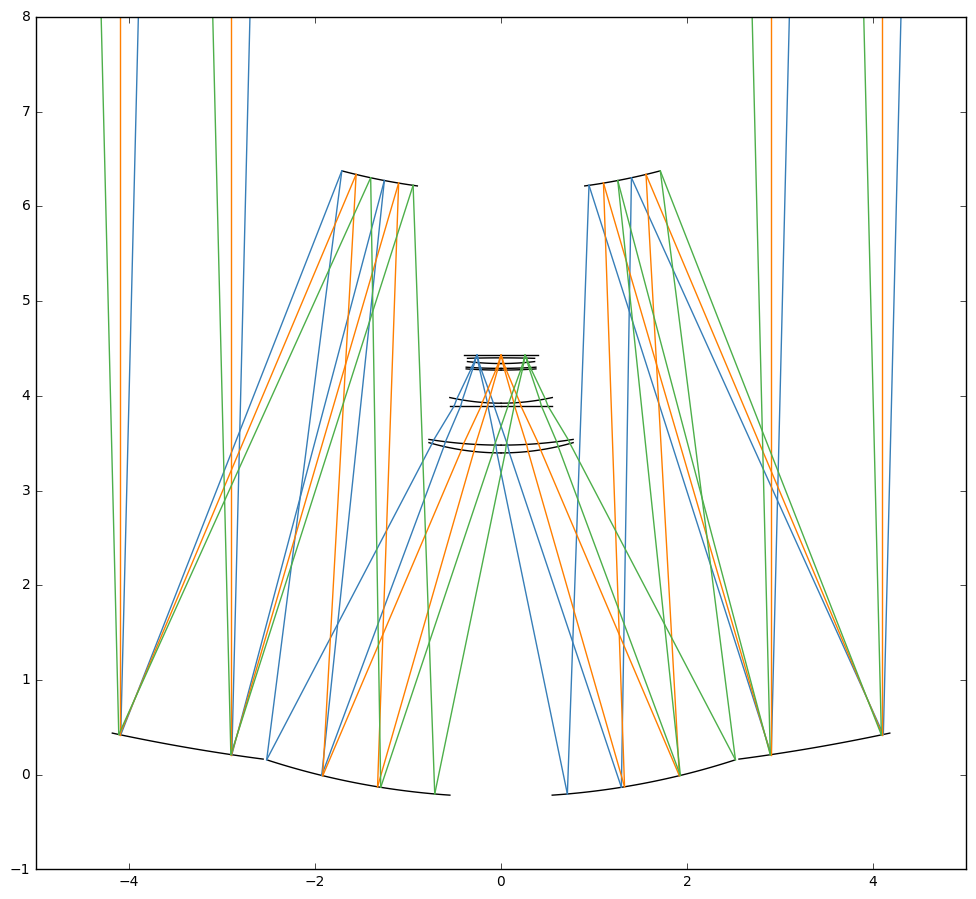

In [4]:
plt.figure(figsize=(12, 11))
for surface in telescope.surfaces.values():
    x = np.linspace(-surface['outer'], -surface['inner'], 100, endpoint=True)
    plt.plot(x, [surface['surface'](x_,0) for x_ in x], c='k')
    x = np.linspace(surface['inner'], surface['outer'], 100, endpoint=True)
    plt.plot(x, [surface['surface'](x_,0) for x_ in x], c='k')

p0_left = jtrace.Vec3(-4.1, 0, 0)
p0_right = jtrace.Vec3(4.1, 0, 0)
p0_lmid = jtrace.Vec3(-2.9, 0, 0)
p0_rmid = jtrace.Vec3(2.9, 0, 0)
v_left = jtrace.Vec3(-0.025, 0, -1).UnitVec3()/1.000277
v_mid = jtrace.Vec3(0, 0, -1).UnitVec3()/1.000277
v_right = jtrace.Vec3(0.025, 0, -1).UnitVec3()/1.000277

for v, c in zip([v_left, v_mid, v_right], ['#377eb8', '#ff7f00', '#4daf4a']):
    for p0 in [p0_left, p0_lmid, p0_rmid, p0_right]:
        ray = jtrace.Ray(p0, v, t=0, w=0.5)
        p0 = ray(-8)
        ray = jtrace.Ray(p0, v, t=0, w=0.5)
        telescope.trace(ray, ax=plt.gca(), color=c)

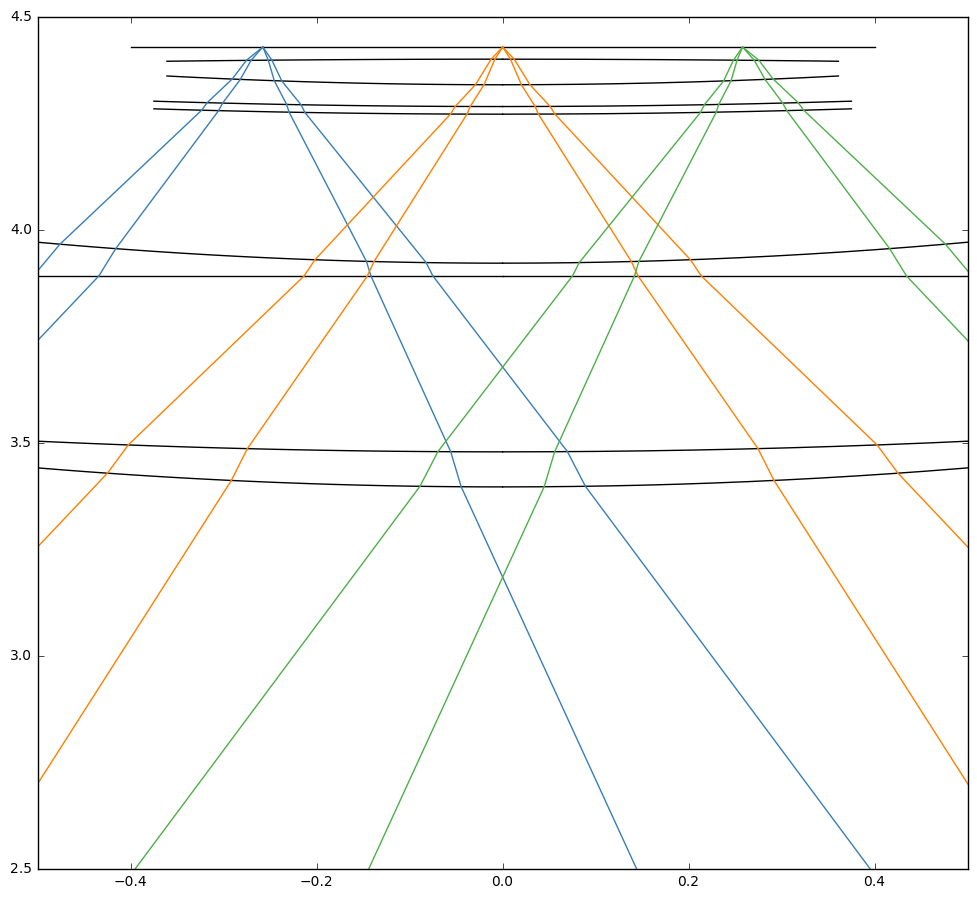

In [5]:
plt.figure(figsize=(12, 11))
for surface in telescope.surfaces.values():
    x = np.linspace(-surface['outer'], -surface['inner'], 100, endpoint=True)
    plt.plot(x, [surface['surface'](x_,0) for x_ in x], c='k')
    x = np.linspace(surface['inner'], surface['outer'], 1000, endpoint=True)
    plt.plot(x, [surface['surface'](x_,0) for x_ in x], c='k')

p0_left = jtrace.Vec3(-4.1, 0, 0)
p0_right = jtrace.Vec3(4.1, 0, 0)
p0_lmid = jtrace.Vec3(-2.9, 0, 0)
p0_rmid = jtrace.Vec3(2.9, 0, 0)
v_left = jtrace.Vec3(-0.025, 0, -1).UnitVec3()/1.000277
v_mid = jtrace.Vec3(0, 0, -1).UnitVec3()/1.000277
v_right = jtrace.Vec3(0.025, 0, -1).UnitVec3()/1.000277

for v, c in zip([v_left, v_mid, v_right], ['#377eb8', '#ff7f00', '#4daf4a']):
    for p0 in [p0_left, p0_lmid, p0_rmid, p0_right]:
        ray = jtrace.Ray(p0, v, t=0, w=0.5)
        p0 = ray(-8)
        ray = jtrace.Ray(p0, v, t=0, w=0.5)
        telescope.trace(ray, ax=plt.gca(), color=c)
plt.ylim(2.5, 4.5)
plt.xlim(-0.5, 0.5)
pass